## Linear Model (csv_v2)

In [1]:
#importing the required libraries libraries
import warnings, requests, zipfile, io

warnings.simplefilter("ignore")
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split
import numpy as np
import sagemaker.amazon.common as smac
from sagemaker.image_uris import retrieve
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Matplotlib is building the font cache; this may take a moment.


In [2]:
import logging

# importing boto3
from botocore.exceptions import ClientError

def initialize_s3_container(storage_name, locality=None):
    try:
        # if no locality is provided, use default aws region and create s3 client
        if locality is None:
            s3_service = boto3.client("s3")
            s3_service.create_bucket(Bucket=storage_name)
        else:
            s3_service = boto3.client("s3", region_name=locality)
            config_location = {"LocationConstraint": locality}
            s3_service.create_bucket(
                Bucket=storage_name, CreateBucketConfiguration=config_location
            )

    except ClientError as error_log:
        logging.error(error_log)
        return False
    #printing the message after successful creation
    print(f"S3 Bucket: {storage_name} has been successfully created.")
    return True

## Bucket Verification

In [3]:
#function to check if the bucket exists
def bucket_check(bucket_name):
    s3 = boto3.client("s3")
    try:
        #checking if the bucket exists using head_bucket
        s3.head_bucket(Bucket=bucket_name)
        print(f"Bucket '{bucket_name}' already exists.")
        return True
    except ClientError as e:
        #handling the 404 error if the bucket does not exist
        if e.response["Error"]["Code"] == "404":
            print(f"Bucket '{bucket_name}' does not exist.")
            return False
        else:
            #raising any other error if it occurs
            raise

## Bucket setup

In [15]:
## setting the s3 bucket name, fetching the s3 resource, checking if the bucket exists, and creating it if not
bucket_dsts = "u3268702-dsts-rohit-bucket-1"
s3_instance = boto3.Session().resource("s3")
container_exists = bucket_check(bucket_dsts)
if not container_exists:
    initialize_s3_container(bucket_dsts)

Bucket 'u3268702-dsts-rohit-bucket-1' does not exist.
S3 Bucket: u3268702-dsts-rohit-bucket-1 has been successfully created.


In [16]:
# setting the prefix and defining a function to upload a csv file to aws s3

prefix = "oncloud"

def upload_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    print(s3_instance.Bucket(bucket_dsts))
    s3_instance.Bucket(bucket_dsts).Object(os.path.join(prefix, folder, filename)).put(
        Body=csv_buffer.getvalue()
    )

### Reading the data

In [17]:
#loading the data
df_v1 = pd.read_csv("./combined_csv_v2.csv")

print(df_v1.head())
print(df_v1.shape)

   target  Distance  DepHourofDay  AWND_O  PRCP_O  TAVG_O  AWND_D  PRCP_D  \
0     0.0     689.0            21      33       0    54.0      30       0   
1     0.0     731.0             9      39       0   136.0      33       0   
2     0.0    1199.0            18      33       0    54.0      77       0   
3     0.0    1587.0            16      33       0    54.0      20       0   
4     0.0    1587.0             7      20       0   165.0      33       0   

   TAVG_D  SNOW_O  ...  Origin_SFO  Dest_CLT  Dest_DEN  Dest_DFW  Dest_IAH  \
0   130.0     0.0  ...       False     False     False     False      True   
1    54.0     0.0  ...       False     False     False     False     False   
2    68.0     0.0  ...       False     False      True     False     False   
3   165.0     0.0  ...       False     False     False     False     False   
4    54.0     0.0  ...       False     False     False     False     False   

   Dest_LAX  Dest_ORD  Dest_PHX  Dest_SFO  is_holiday_1  
0     Fals

In [18]:
#creating the copy of the original data
df=df_v1.copy()

In [20]:
#converting all boolean values to 1 and 0
df = df.replace({True: 1, False: 0})

In [21]:
df.head()

,target,Distance,DepHourofDay,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,...,Origin_SFO,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_1
0,0.0,689.0,21,33,0,54.0,30,0,130.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,0.0,731.0,9,39,0,136.0,33,0,54.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1199.0,18,33,0,54.0,77,0,68.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3,0.0,1587.0,16,33,0,54.0,20,0,165.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,0.0,1587.0,7,20,0,165.0,33,0,54.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#checking the null values
df.isnull().sum()

target          0
Distance        0
DepHourofDay    0
AWND_O          0
PRCP_O          0
               ..
Dest_LAX        0
Dest_ORD        0
Dest_PHX        0
Dest_SFO        0
is_holiday_1    0
Length: 86, dtype: int64

### Split the dataset

In [23]:
#spliting the dataset into train, test and validation (70,15,15)
train, test_and_validate = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df["target"]
)
test, validate = train_test_split(
    test_and_validate,
    test_size=0.5,
    random_state=42,
    stratify=test_and_validate["target"],
)

In [24]:
#printing the shape
print(train.shape)
print(test.shape)
print(validate.shape)

(1144913, 86)
(245338, 86)
(245339, 86)


In [25]:
#changing the names for the files to upload to the bucket
train_file = "data_v1_train.csv"
test_file = "data_v1_test.csv"
validate_file = "data_v1_validate.csv"

In [26]:
#uploading each dataset subset to the specified S3 locations
upload_csv(train_file, "train", train)
upload_csv(test_file, "test", test)
upload_csv(validate_file, "validate", validate)

s3.Bucket(name='u3268702-dsts-rohit-bucket-1')
s3.Bucket(name='u3268702-dsts-rohit-bucket-1')
s3.Bucket(name='u3268702-dsts-rohit-bucket-1')


In [27]:
# this function prepares data from a dataframe for training in amazon sagemaker
# it converts features and labels into numpy arrays of type float32
# writes the data into an in-memory buffer (named as buffer) as dense tensors
# and returns the buffer for use in the sagemaker training process

def prepare_data(df):
    vectors = df.drop(columns=["target"]).values.astype("float32")
    labels = df["target"].values.astype("float32")
    buffer = io.BytesIO()
    smac.write_numpy_to_dense_tensor(buffer, vectors, labels)
    buffer.seek(0)

    return buffer

In [28]:
# this function uploads the training data from an in-memory buffer to s3
# it saves the data under a specified bucket and prefix in a recordio protobuf format
# constructs the s3 data path, prints the upload confirmation, and returns the s3 path

def upload_buffer(buffer, bucket_dsts, prefix, type):
    key = "recordio-pb-data"
    boto3.resource("s3").Bucket(bucket_dsts).Object(
        os.path.join(prefix, type, key)
    ).upload_fileobj(buffer)
    s3_data_path = "s3://{}/{}/{}/{}".format(bucket_dsts, prefix, type, key)
    print("uploaded {} data to location: {}".format(type, s3_data_path))
    return s3_data_path

In [29]:
#calling the function to prepare the data
train_buf = prepare_data(train)

#uploading train data
s3_train_data = upload_buffer(train_buf, bucket_dsts, prefix, "train")

uploaded train data to location: s3://u3268702-dsts-rohit-bucket-1/oncloud/train/recordio-pb-data


In [30]:
#we will perform same thing for validaton dataset
validate_buffer = prepare_data(validate)


s3_validate_data = upload_buffer(validate_buffer, bucket_dsts, prefix, "validate")

uploaded validate data to location: s3://u3268702-dsts-rohit-bucket-1/oncloud/validate/recordio-pb-data


In [31]:
#setting the s3 path for storing training artifacts and printing the location
output_location = "s3://{}/{}/output".format(bucket_dsts, prefix)
print("training artifacts will be uploaded to: {}".format(output_location))

training artifacts will be uploaded to: s3://u3268702-dsts-rohit-bucket-1/oncloud/output


In [32]:
#retrieving the amazon sagemaker container for the 'linear-learner' in the 'us-east-1' region
container = retrieve("linear-learner", "us-east-1")

### Model training

In [37]:
#creating a sagemaker session using the boto3 session with the 'us-east-1' region
session = sagemaker.Session(boto3.session.Session(region_name="us-east-1"))

#getting the sagemaker execution role for permissions
role = sagemaker.get_execution_role()

#setting up the sagemaker estimator for the 'linear-learner' algorithm
linear_model = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type="ml.c5.2xlarge",
    output_path=output_location,
    sagemaker_session=session,
)

#configuring hyperparameters for the estimator
linear_model.set_hyperparameters(feature_dim=85, predictor_type="binary_classifier")

#fitting the model with training and validation data from s3, disabling logs
linear_model.fit({"train": s3_train_data, "validation": s3_validate_data}, logs=False)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.



2024-11-04 10:06:55 Starting - Starting the training job.
2024-11-04 10:07:09 Starting - Preparing the instances for training....
2024-11-04 10:07:30 Downloading - Downloading input data.....
2024-11-04 10:08:00 Downloading - Downloading the training image.........
2024-11-04 10:08:51 Training - Training image download completed. Training in progress.........................................................................
2024-11-04 10:15:03 Uploading - Uploading generated training model.
2024-11-04 10:15:11 Completed - Training job completed


In [38]:
#preparing the input data for batch prediction by extracting all columns except the first one from the test set which is our target variable
batch_input_data = test.iloc[:, 1:]
batch_input_filename = "batch-in-linear.csv"

#uploading the prepared csv file to s3
upload_csv(batch_input_filename, "batch-in-linear", batch_input_data)

#defining the s3 paths for the batch prediction input and output
batch_output = "s3://{}/{}/batch-out-linear/".format(bucket_dsts, prefix)
batch_input = "s3://{}/{}/batch-in-linear/{}".format(bucket_dsts, prefix, batch_input_filename)

s3.Bucket(name='u3268702-dsts-rohit-bucket-1')


In [39]:
#creating a transformer for the linear learner model and starting a batch transform job
#the transformer is configured with specific instance settings and output location
#then, it performs the batch transform on the input data from s3 and waits for the job to complete

linear_transformer = linear_model.transformer(
    instance_count=1,
    instance_type="ml.c5.4xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path=batch_output,
)

linear_transformer.transform(
    data=batch_input,
    data_type="S3Prefix",
    content_type="text/csv",
    split_type="Line",
    logs=False,
)

linear_transformer.wait()

.............................................................................!
2024-11-04T10:21:49.599:[sagemaker logs]: MaxConcurrentTransforms=16, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/04/2024 10:21:46 INFO 140120175003456] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[11/04/2024 10:21:48 WARNING 140120175003456] Loggers have already been setup.
[11/04/2024 10:21:48 INFO 1401201750

In [40]:
#fetching and reading the output data from s3 after batch prediction
#the output is read into a pandas dataframe for further processing or analysis

s3 = boto3.client("s3")
obj = s3.get_object(
    Bucket=bucket_dsts,
    Key="{}/batch-out-linear/{}".format(prefix, "batch-in-linear.csv.out"),
)
target_prediction_df = pd.read_csv(
    io.BytesIO(obj["Body"].read()), header=None, names=["class"]
)

#printing the head
target_prediction_df.head(5)

,class
"{""predicted_label"":0",score:0.092295482754707}
"{""predicted_label"":0",score:0.150472730398178}
"{""predicted_label"":0",score:0.09202516824007}
"{""predicted_label"":0",score:0.127865061163902}
"{""predicted_label"":0",score:0.150395348668098}


In [41]:
#extracting prediction indices, labels, and scores from the dataframe, converting them to numeric type

predicted_indices = target_prediction_df.index
predicted_indices[0][-1]
target_prediction_df.iloc[0, 0][6:-1]
predicted_labels = [str(pred_index)[-1] for pred_index in predicted_indices]
predicted_scores = [str(row[0])[6:-1] for row in target_prediction_df.itertuples(index=False)]
predicted_scores = pd.to_numeric(predicted_scores)
predicted_labels = pd.to_numeric(predicted_labels)

## Results

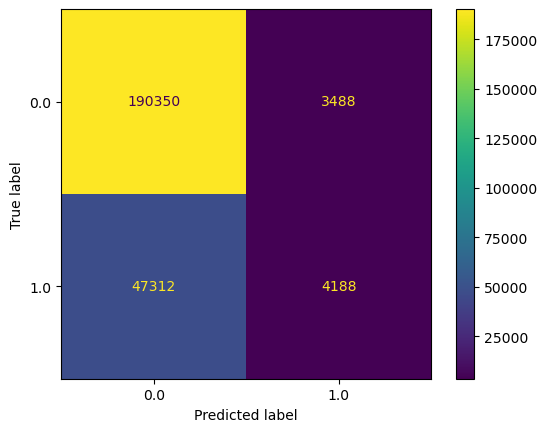

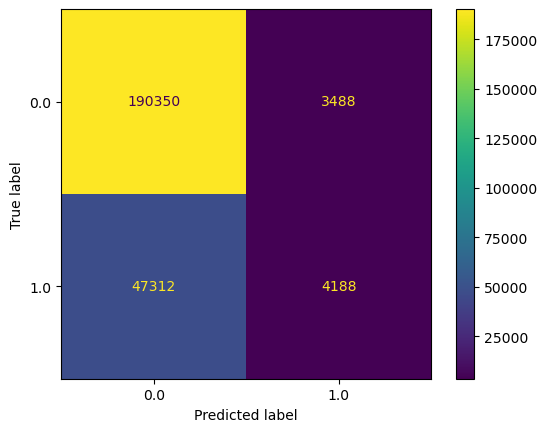

In [42]:
#plotting the confusion matrix
ConfusionMatrixDisplay.from_predictions(test.iloc[:, 0], predicted_labels, cmap='viridis').plot()
plt.show()

In [43]:
#classification report
print("Classification Report on Test Data")
print(classification_report(test.iloc[:, 0], predicted_labels))

Classification Report on Test Data
              precision    recall  f1-score   support

         0.0       0.80      0.98      0.88    193838
         1.0       0.55      0.08      0.14     51500

    accuracy                           0.79    245338
   macro avg       0.67      0.53      0.51    245338
weighted avg       0.75      0.79      0.73    245338



** Model Comparison*

Linear Model on CSV v2: 
    - Performance on Non-Delayed Flights (Class 0): Precision: 0.80 
            - Recall: 0.98 (Almost all non-delayed flights are correctly identified) 
    - Performance on Delayed Flights (Class 1): 
            Precision: 0.55 
            - Recall: 0.08 (Only a small fraction of delayed flights are detected) 
    True Positives for Delayed Flights: 4,188 

Linear Model on CSV (Other Version): 
    - Performance on Non-Delayed Flights (Class 0): Precision: 0.79 
        - Recall: 1.00 (Nearly perfect identification of non-delayed flights) 
    - Performance on Delayed Flights (Class 1): Precision: 0.53 
        - Recall: 0.01 (Very few delayed flights are detected) 
    True Positives for Delayed Flights: 324 

Conclusion: The Linear Model on CSV v2 is better at identifying delayed flights (Class 1), with higher recall and more true positives. However, it still struggles overall, as most delayed flights are missed. Both models are highly skewed toward predicting non-delayed flights (Class 0), but CSV v2 provides a slight improvement in detecting delays.